In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# dataset directory
import os
dir_datasets = '/content/drive/MyDrive/bell_pepper_dataset/train'
print(os.listdir(dir_datasets))

['Mosaic virus', 'Bell pepper Healthy', 'Curling leaves', 'Bacterial spot', 'Yellowing leaves']


In [3]:
# check the amount of data

import glob
total_img = len(list(glob.iglob('/content/drive/MyDrive/bell_pepper_dataset/train/*/*.*', recursive=True)))
print("total images: ", total_img)


total images:  5583


In [4]:
# split data

!pip install split-folders
import splitfolders

splitfolders.ratio(dir_datasets, output='/content/drive/MyDrive/output/', seed=1337, ratio=(.8, .2))

Copying files: 5583 files [03:42, 25.05 files/s] 


In [5]:
# define train, val directory and base directory

base_dir = '/content/drive/MyDrive/output/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [6]:
# Image Augmentation

In [7]:
# image data generator

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale=1./255 )

In [8]:
# data augmentation
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 100,
    color_mode = "rgb",
    class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (224, 224),
    batch_size = 100,
    color_mode = "rgb",
    class_mode = 'categorical')

Found 4464 images belonging to 5 classes.
Found 1119 images belonging to 5 classes.


In [9]:
# check class

class_dict = train_set.class_indices
myList = list(class_dict.keys())
myList

['Bacterial spot',
 'Bell pepper Healthy',
 'Curling leaves',
 'Mosaic virus',
 'Yellowing leaves']

In [10]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.applications import VGG16, ResNet50, InceptionV3
from keras.applications.resnet50 import preprocess_input as preprocess_resnet
from keras.applications.inception_v3 import preprocess_input as preprocess_inception


# sequential models

cnn_input = tf.keras.layers.Input(shape=(224, 224, 3))

cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation= 'softmax')
])


# Load pre-trained models
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers in pretrained models
for model in [vgg_base, resnet_base, inception_base]:
    for layer in model.layers:
        layer.trainable = False

# Get the output tensors of the pre-trained models
vgg_output = vgg_base(cnn_input)
resnet_output = resnet_base(cnn_input)
inception_output = inception_base(cnn_input)


# Concatenate the outputs
combined_output = tf.keras.layers.concatenate([cnn_model(cnn_input),
                                               tf.keras.layers.Flatten()(vgg_output),
                                               tf.keras.layers.Flatten()(resnet_output),
                                               tf.keras.layers.Flatten()(inception_output)])

# Add dense layers for classification
x = tf.keras.layers.Dense(512, activation='relu')(combined_output)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(x)


# Create combined model
model = tf.keras.models.Model(inputs=cnn_input, outputs=output_layer)


In [11]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])


In [12]:
# see model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [13]:
# mycallback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    accuracy=0.92
    if(logs.get('accuracy')>accuracy and logs.get('val_accuracy')>=accuracy):
      print("\nTarget reached %2.2f%%. Stop Training!!" %(accuracy*100))
      self.model.stop_training = True

callbacks = myCallback()

In [14]:
# fitting models
history = model.fit(train_set,
                    epochs=23,
                    steps_per_epoch = train_set.samples // 100,
                    validation_data=validation_set,
                    validation_steps = validation_set.samples // 100,
                    verbose=1,
                    callbacks = [callbacks])


Epoch 1/23
44/44 [==============================] - 86s 2s/step - loss: 1.3319 - accuracy: 0.4661 - val_loss: 1.5044 - val_accuracy: 0.5191
Epoch 2/23
44/44 [==============================] - 85s 2s/step - loss: 0.8892 - accuracy: 0.6297 - val_loss: 0.7850 - val_accuracy: 0.6845
Epoch 3/23
44/44 [==============================] - 86s 2s/step - loss: 0.7842 - accuracy: 0.6654 - val_loss: 0.8179 - val_accuracy: 0.7300
Epoch 4/23
44/44 [==============================] - 85s 2s/step - loss: 0.6936 - accuracy: 0.7156 - val_loss: 0.6306 - val_accuracy: 0.7418
Epoch 5/23
44/44 [==============================] - 86s 2s/step - loss: 0.6408 - accuracy: 0.7358 - val_loss: 0.6091 - val_accuracy: 0.7964
Epoch 6/23
44/44 [==============================] - 85s 2s/step - loss: 0.6361 - accuracy: 0.7415 - val_loss: 0.5754 - val_accuracy: 0.7582
Epoch 7/23
44/44 [==============================] - 86s 2s/step - loss: 0.5330 - accuracy: 0.7867 - val_loss: 0.4562 - val_accuracy: 0.8145
Epoch 8/23
44/44 [==

In [15]:
# Evaluating Model Performance

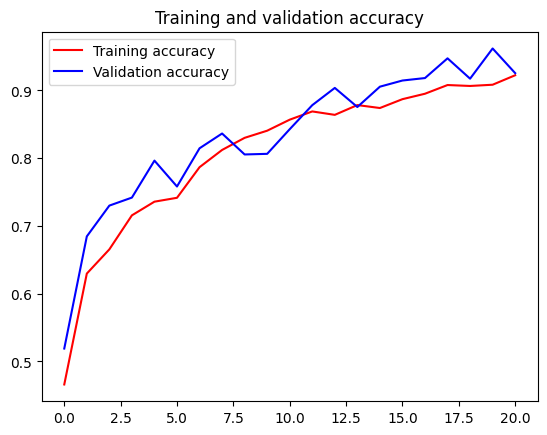

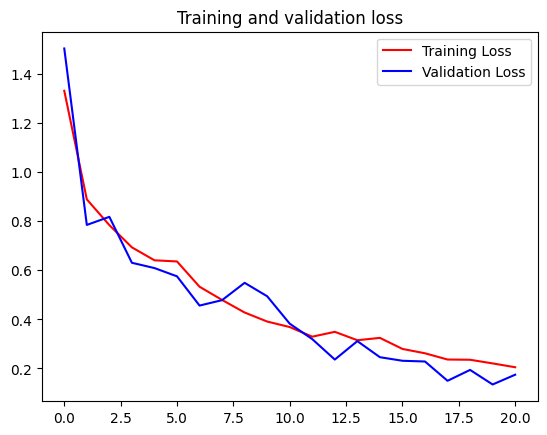

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
# Making Predictions

Saving BellPepperHealthy_142.jpg to BellPepperHealthy_142.jpg
1/1 [==============================] - 0s 115ms/step


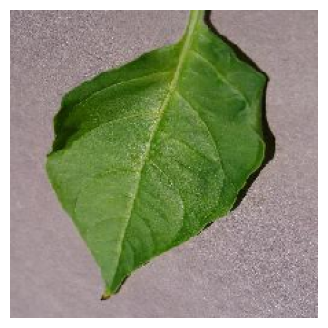

prediction: Bell pepper Healthy


In [18]:
# predicting images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  new_img = image.load_img(path, target_size=(224, 224))
  img = image.img_to_array(new_img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  prediction = model.predict(img)

  x = prediction.flatten()
  j = x.max()
  for index, item in enumerate(x):
      if item == j:
          class_name = myList[index]

  # plot img
  plt.figure(figsize = (4,4))
  plt.imshow(new_img)
  plt.axis('off')
  plt.show()

  print("prediction:", class_name)

Saving BacterialSpot_108.jpg to BacterialSpot_108.jpg
1/1 [==============================] - 0s 44ms/step


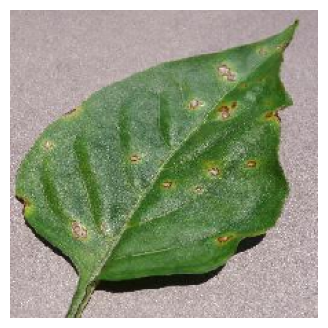

prediction: Bacterial spot


In [19]:
# predicting images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  new_img = image.load_img(path, target_size=(224, 224))
  img = image.img_to_array(new_img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  prediction = model.predict(img)

  x = prediction.flatten()
  j = x.max()
  for index, item in enumerate(x):
      if item == j:
          class_name = myList[index]

  # plot img
  plt.figure(figsize = (4,4))
  plt.imshow(new_img)
  plt.axis('off')
  plt.show()

  print("prediction:", class_name)

Saving curling leaf_104.jpg to curling leaf_104.jpg
1/1 [==============================] - 0s 43ms/step


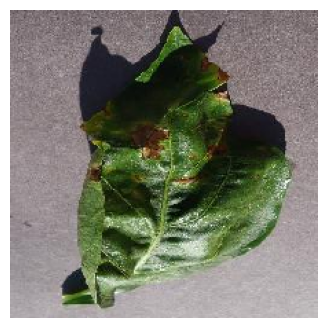

prediction: Curling leaves


In [20]:
# predicting images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  new_img = image.load_img(path, target_size=(224, 224))
  img = image.img_to_array(new_img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  prediction = model.predict(img)

  x = prediction.flatten()
  j = x.max()
  for index, item in enumerate(x):
      if item == j:
          class_name = myList[index]

  # plot img
  plt.figure(figsize = (4,4))
  plt.imshow(new_img)
  plt.axis('off')
  plt.show()

  print("prediction:", class_name)

Saving Mosaic virus_66.jpg to Mosaic virus_66.jpg
1/1 [==============================] - 0s 41ms/step


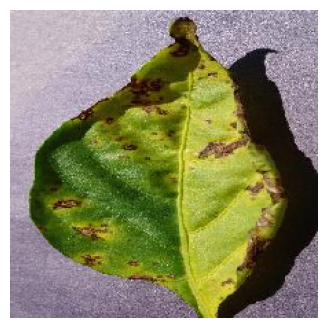

prediction: Mosaic virus


In [22]:
# predicting images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  new_img = image.load_img(path, target_size=(224, 224))
  img = image.img_to_array(new_img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  prediction = model.predict(img)

  x = prediction.flatten()
  j = x.max()
  for index, item in enumerate(x):
      if item == j:
          class_name = myList[index]

  # plot img
  plt.figure(figsize = (4,4))
  plt.imshow(new_img)
  plt.axis('off')
  plt.show()

  print("prediction:", class_name)

Saving yellowing leaf_158.jpg to yellowing leaf_158.jpg
1/1 [==============================] - 0s 44ms/step


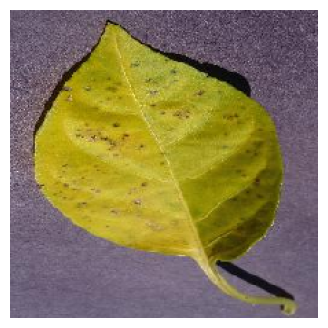

prediction: Yellowing leaves


In [23]:
# predicting images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  new_img = image.load_img(path, target_size=(224, 224))
  img = image.img_to_array(new_img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  prediction = model.predict(img)

  x = prediction.flatten()
  j = x.max()
  for index, item in enumerate(x):
      if item == j:
          class_name = myList[index]

  # plot img
  plt.figure(figsize = (4,4))
  plt.imshow(new_img)
  plt.axis('off')
  plt.show()

  print("prediction:", class_name)

In [24]:
# models conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)


In [25]:
model.save("models/topmodel.hdf5", save_format="h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
